# I. Imports

In [13]:
# External libraries

import numpy as np
import matplotlib.pyplot as plt

# Internal imports

from src.data import X, y, d
from src.aggregationFunctions import uniform_agg, gaussian_agg
from src.functions import *
from src.samplers import cmc
from src.variationalObjective import variational_obj
from src.gradientDescent import gradient_descent_W
from src.samplers import gibbs_sampler

# II. Sample from data using CMC

In [14]:
ncores = 10
W = np.array([np.eye(d) for k in range(ncores)])
betas = cmc(
    X = X,
    y = y,
    ncores=ncores,
    nsim=100,
    burnin=10
)

# III. Gradient descent

In [15]:
lr = 1
niter = 10
tol = 1e-6
sigma = 1

K,nsamples,d=betas.shape
S = np.array([np.mean([np.outer(betas[k,i],betas[k,i]) for i in range(nsamples)],axis=0) for k in range(K)])
mu = np.mean(betas,axis=1)
W = np.array([np.eye(d)/K for _ in range(K)]) #usual initialisation

W = gradient_descent_W(
    W_0 = W,
    S = S,
    mu = mu,
    betas = betas, 
    X = X,
    y = y,
    learning_rate = lr,
    niter = niter,
    tolerance = tol
)

iter: 0
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9


In [16]:
betas_vcmc=np.sum([(W/np.sum(W,axis=0))[k] @np.mean(betas[k],axis=0) for k in range(K)],axis=0)
betas_vcmc/betas_vcmc[0]

array([ 1.        ,  4.21809744, -8.69069231,  2.77088525,  1.18058774])

# Results

In [20]:
betas=gibbs_sampler(X,y,nsim=2000,burnin=500)

In [21]:
map_estimator=betas.mean(axis=0)
map_estimator/=map_estimator[0]
map_estimator

array([ 1.        , -0.10536487, -0.00796951, -0.32721886, -0.8795144 ])

In [22]:
ncores_list=[5,10,25,50,100]
err_uni=[]
err_gauss=[]
for ncores in ncores_list:
    sub_thetas=cmc(X,y,ncores=ncores,nsim=2000,burnin=500)
    theta_uni=uniform_agg(sub_thetas)
    theta_gauss=gaussian_agg(sub_thetas)
    theta_uni/=theta_uni[0]
    theta_gauss/=theta_gauss[0]
    err_uni.append(np.linalg.norm(map_estimator-theta_uni,ord=1)/np.linalg.norm(map_estimator,ord=1))
    err_gauss.append(np.linalg.norm(map_estimator-theta_gauss,ord=1)/np.linalg.norm(map_estimator,ord=1))

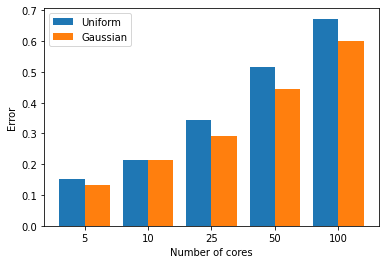

In [23]:
X_axis = np.arange(len(ncores_list))
plt.bar(X_axis - 0.2,err_uni, 0.4, label = 'Uniform')
plt.bar(X_axis + 0.2,err_gauss, 0.4, label = 'Gaussian')
plt.xticks(X_axis, ncores_list)
plt.xlabel("Number of cores")
plt.ylabel("Error")
plt.legend()
plt.show()